In [1]:
from xgboost_feature_analysis import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import plot_tree
from xgboost import XGBRegressor
from xgboost import plot_importance
from copy import deepcopy

xgboost_feature_analysis is a set of functions that will analyze feature importance for XGBoost models when certain features are fixed at various values.

We begin by defining the following function, which is highly dependent on $y$ when $x < .5$, but not very dependent on $y$ when $x \geq .5$:

$$f(x,y) = \left\{
\begin{array}{ll}
      \sin(y) & x < .5 \\
      .01 \sin(y) & x \geq .5 \\
\end{array} 
\right.$$

We'll then use XGBoost to approximate this function.  We would expect that the learning algorithm will split much more on $y$ when $x < .5$, and much less when $x \geq .5$.  

In [2]:
def f(x,y):
    return np.sin(y) if x < .5 else .01 * np.sin(y) 

In [3]:
model = XGBRegressor()
model.set_params(**{'n_estimators':200, 'learning_rate':.05, 'base_score':0, 'colsample_bytree':1,  'max_depth':5})

N = 5000


array = np.random.rand(N,2)
data = pd.DataFrame(array)

data.columns = ['x','y']
#data['output'] = data.apply(lambda row: 1 if row['x']**2 + row['y']**2 < 1 else 0, axis = 1)




data['output'] = data.apply(lambda row: f(row['x'], row['y']), axis = 1)
data

X = data[['x', 'y']]
Y = data['output']

model.fit(X,Y)
#forest = get_forest(model)
#print forest
#data['prediction'] = model.predict(X)
#data['my_pred'] = data.apply(lambda x: evaluate_model(model, x), axis = 1)
#data['diff'] = data['prediction'] - data['my_pred']
data 

data['prediction'] = model.predict(X)
data['err'] = abs(data['output'] - data['prediction'])

print "Mean error on training data:", data['err'].mean()




test_data = pd.DataFrame(np.random.rand(N,2))
test_data.columns = ['x','y']
test_data['output'] = test_data.apply(lambda row: f(row['x'], row['y']), axis = 1)


test_data['prediction'] = model.predict(test_data[['x','y']])
test_data['err'] = abs(test_data['output'] - test_data['prediction'])

print "Mean error on test set:", test_data['err'].mean()




Mean error on training data: 0.000193854947844
Mean error on test set: 0.000244510113807


Using XGBoost's plot_feature_importance we can get the F-score's (number of splits in trees) for each variable.  We can reproduce this using the function plot_importance from xgboost_feature_analysis, as a check that it is correct.

{'Fscore_y': 2675, 'Fscore_x': 349}


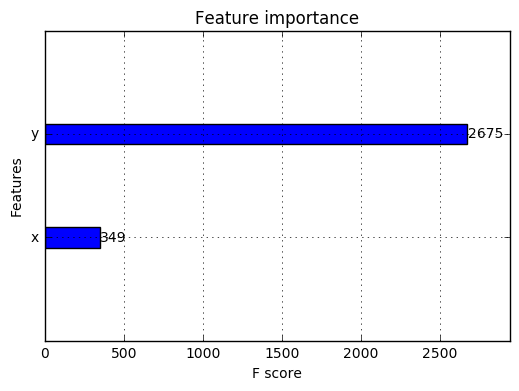

In [4]:
print get_feature_importance(get_forest(model))
plot_importance(model)
plt.show()

However, there is no way in XGBoost to get feature importance for $y$ at different fixed values of $x$.  This we can do using xgboost_feature_analysis.  This algorithm works by contracting and pruning each of the trees in the XGBoost model appropriately for each fixed value of $x$.

In [5]:
npoints = 10

points = [{'x': i/float(npoints)} for i in range(npoints+1) ]
points
df = pd.DataFrame( get_feature_importance_at_points(model, points) )
df[['x', 'Fscore_y']]

,x,Fscore_y
0,0.0,2053
1,0.1,2053
2,0.2,2053
3,0.3,2052
4,0.4,2056
5,0.5,2051
6,0.6,646
7,0.7,646
8,0.8,646
9,0.9,646


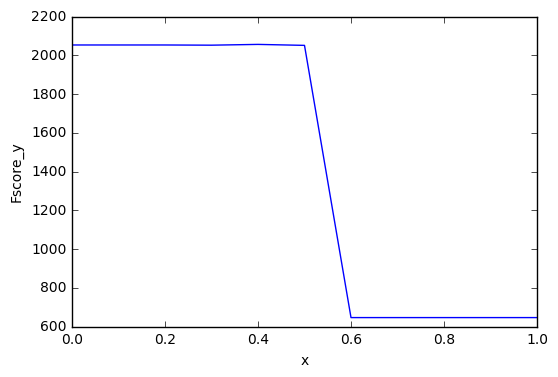

In [6]:
plt.clf()
plt.plot(df.set_index('x'))

plt.xlabel('x')
plt.ylabel('Fscore_y')

plt.show()

Thus as expected, we can see that XGBoost's learning algorithm splits much more on $y$ when $x < .5$, since there is little variation in $f$ as a function of $y$ when $x \geq .5$.